In [1]:
import pandas as pd
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap, BoundaryNorm
import pydot
import pydotplus
import re
import numpy
import seaborn as sn
from sklearn import neighbors
import matplotlib.patches as mpatches
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches
from sklearn.preprocessing import LabelEncoder
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Plot Functions

In [2]:
def plot_decision_tree(clf, feature_names, class_names):
    # This function requires the pydotplus module and assumes it's been installed.
    # In some cases (typically under Windows) even after running conda install, there is a problem where the
    # pydotplus module is not found when running from within the notebook environment.  The following code
    # may help to guarantee the module is installed in the current notebook environment directory.
    #
    # import sys; sys.executable
    # !{sys.executable} -m pip install pydotplus

    export_graphviz(clf, out_file="adspy_temp.dot", feature_names=feature_names, class_names=class_names, filled = True, impurity = False)
    #PATH = '/Users/chieh/Desktop/Milestone II/adspy_temp.dot'
    #f = str(pydot.graph_from_dot_file(PATH))
    #f = re.sub('(\\\\nsamples = [0-9]+)(\\\\nvalue = \[([0-9]+,)+\])', '', f)
    #f = re.sub('(samples = [0-9]+)(\\\\nvalue = \[([0-9]+,)+\])\\\\n', '', f)

    #with open('adspy_temp.dot', 'w') as file:
    #    dot_graph = file.write(f)
    with open("adspy_temp.dot") as f:
        dot_graph = f.read()
    # Alternate method using pydotplus, if installed.
    #graph = pydotplus.graphviz.graph_from_dot_data(dot_graph)
    #return graph.create_png()
    return graphviz.Source(dot_graph)

def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(numpy.arange(c_features), feature_names)

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(numpy.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()


def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = numpy.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X.iloc[:, 0].min()
    x_max = X.iloc[:, 0].max()
    y_min = X.iloc[:, 1].min()
    y_max = X.iloc[:, 1].max()
    x2, y2 = numpy.meshgrid(numpy.arange(x_min-k, x_max+k, h), numpy.arange(y_min-k, y_max+k, h))

    P = clf.predict(numpy.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)


def plot_class_regions_for_classifier(clf, X, y, X_test=None, y_test=None, title=None, target_names = None, plot_decision_regions = True):

    numClasses = numpy.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X.iloc[:, 0].min()
    x_max = X.iloc[:, 0].max()
    y_min = X.iloc[:, 1].min()
    y_max = X.iloc[:, 1].max()
    x2, y2 = numpy.meshgrid(numpy.arange(x_min-k, x_max+k, h), numpy.arange(y_min-k, y_max+k, h))

    P = clf.predict(numpy.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    plt.figure()
    if plot_decision_regions:
        plt.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()

def plot_fruit_knn(X, y, n_neighbors, weights):
    X_mat = X[['height', 'width']].as_matrix()
    y_mat = y.as_matrix()

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF','#AFAFAF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#AFAFAF'])

    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.

    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50

    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, mesh_step_size),
                         numpy.arange(y_min, y_max, mesh_step_size))
    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    patch0 = mpatches.Patch(color='#FF0000', label='apple')
    patch1 = mpatches.Patch(color='#00FF00', label='mandarin')
    patch2 = mpatches.Patch(color='#0000FF', label='orange')
    patch3 = mpatches.Patch(color='#AFAFAF', label='lemon')
    plt.legend(handles=[patch0, patch1, patch2, patch3])


    plt.xlabel('height (cm)')
    plt.ylabel('width (cm)')

    plt.show()

def plot_two_class_knn(X, y, n_neighbors, weights, X_test, y_test):
    X_mat = X
    y_mat = y

    # Create color maps
    cmap_light = ListedColormap(['#FFFFAA', '#AAFFAA', '#AAAAFF','#EFEFEF'])
    cmap_bold  = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.

    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50

    x_min, x_max = X_mat.iloc[:, 0].min() - 1, X_mat.iloc[:, 0].max() + 1
    y_min, y_max = X_mat.iloc[:, 1].min() - 1, X_mat.iloc[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, mesh_step_size),
                         numpy.arange(y_min, y_max, mesh_step_size))
    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    title = "Neighbors = {}".format(n_neighbors)
    if (X_test is not None):
        train_score = clf.score(X_mat, y_mat)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    patch0 = mpatches.Patch(color='#FFFF00', label='class 0')
    patch1 = mpatches.Patch(color='#000000', label='class 1')
    plt.legend(handles=[patch0, patch1])

    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.title(title)

    plt.show()



# ROCAUC function

In [3]:
import numpy as np

from yellowbrick.exceptions import ModelError
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.style.palettes import LINE_COLOR
from yellowbrick.classifier.base import ClassificationScoreVisualizer

from scipy import interp
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve


# Dictionary keys for ROCAUC
MACRO = "macro"
MICRO = "micro"


##########################################################################
## ROCAUC Visualizer
##########################################################################

class ROCAUC(ClassificationScoreVisualizer):
    """
    Receiver Operating Characteristic (ROC) curves are a measure of a
    classifier's predictive quality that compares and visualizes the tradeoff
    between the models' sensitivity and specificity. The ROC curve displays
    the true positive rate on the Y axis and the false positive rate on the
    X axis on both a global average and per-class basis. The ideal point is
    therefore the top-left corner of the plot: false positives are zero and
    true positives are one.

    This leads to another metric, area under the curve  (AUC), a computation
    of the relationship between false positives and true positives. The higher
    the AUC, the better the model generally is. However, it is also important
    to inspect the "steepness" of the curve, as this describes the
    maximization of the true positive rate while minimizing the false positive
    rate. Generalizing "steepness" usually leads to discussions about
    convexity, which we do not get into here.

    Parameters
    ----------
    model : estimator
        Must be a classifier, otherwise raises YellowbrickTypeError

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    classes : list
        A list of class names for the legend. If classes is None and a y value
        is passed to fit then the classes are selected from the target vector.
        Note that the curves must be computed based on what is in the target
        vector passed to the ``score()`` method. Class names are used for
        labeling only and must be in the correct order to prevent confusion.

    micro : bool, default = True
        Plot the micro-averages ROC curve, computed from the sum of all true
        positives and false positives across all classes.

    macro : bool, default = True
        Plot the macro-averages ROC curve, which simply takes the average of
        curves across all classes.

    per_class : bool, default = True
        Plot the ROC curves for each individual class. This should be set
        to false if only the macro or micro average curves are required.

    kwargs : keyword arguments passed to the super class.
        Currently passing in hard-coded colors for the Receiver Operating
        Characteristic curve and the diagonal.
        These will be refactored to a default Yellowbrick style.

    Attributes
    ----------
    score_ : float
        Global accuracy score, unless micro or macro scores are requested

    Notes
    -----
    ROC curves are typically used in binary classification, and in fact the
    Scikit-Learn ``roc_curve`` metric is only able to perform metrics for
    binary classifiers. As a result it is necessary to binarize the output or
    to use one-vs-rest or one-vs-all strategies of classification. The
    visualizer does its best to handle multiple situations, but exceptions can
    arise from unexpected models or outputs.

    Another important point is the relationship of class labels specified on
    initialization to those drawn on the curves. The classes are not used to
    constrain ordering or filter curves; the ROC computation happens on the
    unique values specified in the target vector to the ``score`` method. To
    ensure the best quality visualization, do not use a LabelEncoder for this
    and do not pass in class labels.

    .. seealso:: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    .. todo:: Allow the class list to filter the curves on the visualization.

    Examples
    --------
    >>> from sklearn.datasets import load_breast_cancer
    >>> from yellowbrick.classifier import ROCAUC
    >>> from sklearn.linear_model import LogisticRegression
    >>> from sklearn.model_selection import train_test_split
    >>> data = load_breast_cancer()
    >>> X = data['data']
    >>> y = data['target']
    >>> X_train, X_test, y_train, y_test = train_test_split(X, y)
    >>> viz = ROCAUC(LogisticRegression())
    >>> viz.fit(X_train, y_train)
    >>> viz.score(X_test, y_test)
    >>> viz.show()
    """

    def __init__(self, model, ax=None, classes=None,
                 micro=True, macro=True, per_class=True, **kwargs):
        super(ROCAUC, self).__init__(model, ax=ax, classes=classes, **kwargs)

        # Set the visual parameters for ROCAUC
        self.micro = micro
        self.macro = macro
        self.per_class = per_class

    def score(self, X, y=None, **kwargs):
        """
        Generates the predicted target values using the Scikit-Learn
        estimator.

        Parameters
        ----------
        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features

        y : ndarray or Series of length n
            An array or series of target or class values

        Returns
        -------
        score_ : float
            Global accuracy unless micro or macro scores are requested.
        """

        # Compute the predictions for the test data
        y_pred = self._get_y_scores(X)
        
        if len(y_pred.shape) == 1:
            self._binary_decision = True
            
            if self.micro or self.macro or self.per_class:
                raise ModelError(
                    "Micro, macro, and per-class scores are not defined for "
                    "binary classification for estimators with only " 
                    "decision_function methods; set micro, macro, and "
                    "per-class params to False."
                )
        else:
            self._binary_decision = False
            if not self.micro and not self.macro and not self.per_class:
                raise YellowbrickValueError(
                    "no curves will be drawn; specify micro, macro, or per_class"
                )
                
        # Classes may be label encoded so only use what's in y to compute.
        # The self.classes_ attribute will be used as names for labels.
        classes = np.unique(y)
        n_classes = len(classes)

        # Store the false positive rate, true positive rate and curve info.
        self.fpr = dict()
        self.tpr = dict()
        self.roc_auc = dict()

        # Compute ROC curve and ROC area for each class
        if self._binary_decision == True:
            self.fpr[0], self.tpr[0], _ = roc_curve(y, y_pred)
            self.roc_auc[0] = auc(self.fpr[0], self.tpr[0])
        else: 
            for i, c in enumerate(classes):
                self.fpr[i], self.tpr[i], _ = roc_curve(y, y_pred[:,i], pos_label=c)
                self.roc_auc[i] = auc(self.fpr[i], self.tpr[i])

        # Compute micro average
        if self.micro:
            self._score_micro_average(y, y_pred, classes, n_classes)

        # Compute macro average
        if self.macro:
            self._score_macro_average(y_pred, n_classes)

        # Draw the Curves
        self.draw()

        # Set score to micro average if specified
        if self.micro:
            self.score_ = self.roc_auc[MICRO]

        # Set score to macro average if not micro
        if self.macro:
            self.score_ = self.roc_auc[MACRO]

        # Set score to the base score if neither macro nor micro
        self.score_ = self.estimator.score(X, y)

        return self.score_

    def draw(self):
        """
        Renders ROC-AUC plot.
        Called internally by score, possibly more than once

        Returns
        -------
        ax : the axis with the plotted figure
        """
        colors = self.colors[0:len(self.classes_)]
        n_classes = len(colors)

        # If binary decision, plot the ROC curve
        if self._binary_decision == True:
            self.ax.plot(
                self.fpr[0], self.tpr[0],
                label='ROC for binary decision, AUC = {:0.2f}'.format(
                        self.roc_auc[0]
                )
            )
        # Otherwise plot the ROC curves for each class
        if self.per_class:
            for i, color in zip(range(n_classes), colors):
                self.ax.plot(
                    self.fpr[i], self.tpr[i], color=color,
                    label='ROC of class {}, AUC = {:0.2f}'.format(
                        self.classes_[i], self.roc_auc[i],
                    )
                )

        # Plot the ROC curve for the micro average
        if self.micro:
            self.ax.plot(
                self.fpr[MICRO], self.tpr[MICRO], linestyle="--",
                color= self.colors[len(self.classes_)-1],
                label='micro-average ROC curve, AUC = {:0.2f}'.format(
                    self.roc_auc["micro"],
                )
            )

        # Plot the ROC curve for the macro average
        if self.macro:
            self.ax.plot(
                self.fpr[MACRO], self.tpr[MACRO], linestyle="--",
                color= self.colors[len(self.classes_)-1],
                label='macro-average ROC curve, AUC = {:0.2f}'.format(
                    self.roc_auc["macro"],
                )
            )

        # Plot the line of no discrimination to compare the curve to.
        self.ax.plot([0,1], [0,1], linestyle=':', c=LINE_COLOR)
        return self.ax

    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls show and show calls finalize.

        Parameters
        ----------
        kwargs: generic keyword arguments.

        """
        # Set the title and add the legend
        self.set_title('ROC Curves for {}'.format(self.name))
        self.ax.legend(loc='lower right', frameon=True)

        # Set the limits for the ROC/AUC (always between 0 and 1)
        self.ax.set_xlim([0.0, 1.0])
        self.ax.set_ylim([0.0, 1.0])

        # Set x and y axis labels
        self.ax.set_ylabel('True Postive Rate')
        self.ax.set_xlabel('False Positive Rate')

    def _get_y_scores(self, X):
        """
        The ``roc_curve`` metric requires target scores that can either be the
        probability estimates of the positive class, confidence values or non-
        thresholded measure of decisions (as returned by "decision_function").

        This method computes the scores by resolving the estimator methods
        that retreive these values.

        .. todo:: implement confidence values metric.

        Parameters
        ----------
        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features -- generally the test data
            that is associated with y_true values.
        """
        # The resolution order of scoring functions
        attrs = (
            'predict_proba',
            'decision_function',
        )

        # Return the first resolved function
        for attr in attrs:
            try:
                method = getattr(self.estimator, attr, None)
                if method:
                    return method(X)
            except AttributeError:
                # Some Scikit-Learn estimators have both probability and
                # decision functions but override __getattr__ and raise an
                # AttributeError on access.
                continue

        # If we've gotten this far, raise an error
        raise ModelError(
            "ROCAUC requires estimators with predict_proba or "
            "decision_function methods."
        )

    def _score_micro_average(self, y, y_pred, classes, n_classes):
        """
        Compute the micro average scores for the ROCAUC curves.
        """
        # Convert y to binarized array for micro and macro scores
        y = label_binarize(y, classes=classes)
        if n_classes == 2:
            y = np.hstack((1-y, y))

        # Compute micro-average
        self.fpr[MICRO], self.tpr[MICRO], _ = roc_curve(y.ravel(), y_pred.ravel())
        self.roc_auc[MICRO] = auc(self.fpr[MICRO], self.tpr[MICRO])

    def _score_macro_average(self, y_pred, n_classes):
        """
        Compute the macro average scores for the ROCAUC curves.
        """   
        # Gather all FPRs
        all_fpr = np.unique(np.concatenate([self.fpr[i] for i in range(n_classes)]))
        avg_tpr = np.zeros_like(all_fpr)

        # Compute the averages per class
        for i in range(n_classes):
            avg_tpr += interp(all_fpr, self.fpr[i], self.tpr[i])

        # Finalize the average
        avg_tpr /= n_classes

        # Store the macro averages
        self.fpr[MACRO] = all_fpr
        self.tpr[MACRO] = avg_tpr
        self.roc_auc[MACRO] = auc(self.fpr[MACRO], self.tpr[MACRO])


##########################################################################
## Quick method for ROCAUC
##########################################################################

def roc_auc(model, X, y=None, ax=None, **kwargs):
    """ROCAUC Quick method:

    Receiver Operating Characteristic (ROC) curves are a measure of a
    classifier's predictive quality that compares and visualizes the tradeoff
    between the models' sensitivity and specificity. The ROC curve displays
    the true positive rate on the Y axis and the false positive rate on the
    X axis on both a global average and per-class basis. The ideal point is
    therefore the top-left corner of the plot: false positives are zero and
    true positives are one.

    This leads to another metric, area under the curve  (AUC), a computation
    of the relationship between false positives and true positives. The higher
    the AUC, the better the model generally is. However, it is also important
    to inspect the "steepness" of the curve, as this describes the
    maximization of the true positive rate while minimizing the false positive
    rate. Generalizing "steepness" usually leads to discussions about
    convexity, which we do not get into here.

    Parameters
    ----------
    model : the Scikit-Learn estimator
        Should be an instance of a classifier, else the __init__ will
        return an error.

    X : ndarray or DataFrame of shape n x m
        A matrix of n instances with m features

    y : ndarray or Series of length n
        An array or series of target or class values

    ax : the axis to plot the figure on.

    classes : list
        A list of class names for the legend. If classes is None and a y value
        is passed to fit then the classes are selected from the target vector.
        Note that the curves must be computed based on what is in the target
        vector passed to the ``score()`` method. Class names are used for
        labeling only and must be in the correct order to prevent confusion.

    micro : bool, default = True
        Plot the micro-averages ROC curve, computed from the sum of all true
        positives and false positives across all classes.

    macro : bool, default = True
        Plot the macro-averages ROC curve, which simply takes the average of
        curves across all classes.

    per_class : bool, default = True
        Plot the ROC curves for each individual class. Primarily this is set
        to false if only the macro or micro average curves are required.

    Notes
    -----
    ROC curves are typically used in binary classification, and in fact the
    Scikit-Learn ``roc_curve`` metric is only able to perform metrics for
    binary classifiers. As a result it is necessary to binarize the output or
    to use one-vs-rest or one-vs-all strategies of classification. The
    visualizer does its best to handle multiple situations, but exceptions can
    arise from unexpected models or outputs.

    Another important point is the relationship of class labels specified on
    initialization to those drawn on the curves. The classes are not used to
    constrain ordering or filter curves; the ROC computation happens on the
    unique values specified in the target vector to the ``score`` method. To
    ensure the best quality visualization, do not use a LabelEncoder for this
    and do not pass in class labels.

    .. seealso:: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    .. todo:: Allow the class list to filter the curves on the visualization.

    Examples
    --------
    >>> from sklearn.datasets import load_breast_cancer
    >>> from yellowbrick.classifier import roc_auc
    >>> from sklearn.linear_model import LogisticRegression
    >>> data = load_breast_cancer()
    >>> roc_auc(LogisticRegression(), data.data, data.target)

    Returns
    -------
    ax : matplotlib axes
        Returns the axes that the roc-auc curve was drawn on.
    """
    # Instantiate the visualizer
    visualizer = ROCAUC(model, ax, **kwargs)

    # Create the train and test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Fit and transform the visualizer (calls draw)
    visualizer.fit(X_train, y_train, **kwargs)
    visualizer.score(X_test, y_test)
    visualizer.finalize()

    # Return the axes object on the visualizer
    return visualizer.ax

# Import Data

In [4]:
df = pd.read_csv('cleaned_wine.csv')
df["region_num"] = df.groupby("country_name", sort=False).ngroup()+1

In [5]:
df.columns

Index(['Unnamed: 0', 'name', 'year', 'wine ID', 'rating', 'price', 'winery',
       'winery_id', 'ratings_count', 'country_name', 'number_of_flavors',
       'black_fruit', 'citrus_fruit', 'dried_fruit', 'earth', 'floral',
       'microbio', 'non_oak', 'oak', 'red_fruit', 'spices', 'tree_fruit',
       'tropical_fruit', 'vegetal', 'region_num'],
      dtype='object')

In [6]:
df_r = df.country_name.value_counts().to_frame()
df_r = df_r.reset_index()
df_r = df_r.rename(columns={'index': 'country', 'country_name': 'count'})
df_r

country  count
0      fr   2023
1      au    738
2      us    295
3      es     88
4      ar     73
5      at      8
6      pt      6
7      cl      5
8      it      4
9      de      2

In [7]:
from sklearn.model_selection import train_test_split

X = df[['black_fruit', 'citrus_fruit', 'dried_fruit', 'earth',
       'floral', 'microbio', 'non_oak', 'oak', 'red_fruit', 'spices',
       'tree_fruit', 'tropical_fruit', 'vegetal']]
y = df['winery']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=0)



# Decision Tree Classifier
## classify winery

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [9]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}' .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}' .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.05


In [10]:
feature_names = ['black_fruit', 'citrus_fruit', 'dried_fruit', 'earth',
       'floral', 'microbio', 'non_oak', 'oak', 'red_fruit', 'spices',
       'tree_fruit', 'tropical_fruit', 'vegetal']
target_names = list(set(df['winery'].to_list()))
plot_decision_tree(clf, feature_names, target_names)

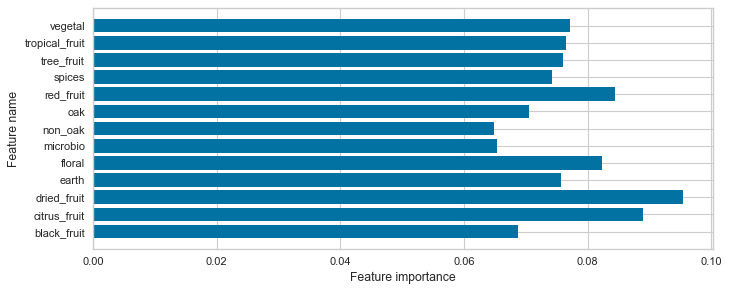

In [11]:
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf, feature_names)
plt.show()

# Random Forest Classifier
## classify winery

In [12]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(n_estimators = 10,
                            random_state=0).fit(X_train, y_train)
print('Random Forest, Flavor dataset, default settings') 
print('Accuracy of RF classifier on training set: {:.2f}'.format(clf.score(X_train, y_train))) 
print('Accuracy of RF classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Random Forest, Flavor dataset, default settings
Accuracy of RF classifier on training set: 0.99
Accuracy of RF classifier on test set: 0.09


# GaussianNB Classifier
## classify winery

In [13]:
from sklearn.naive_bayes import GaussianNB
    
nbclf = GaussianNB().fit(X_train, y_train)
print('Wine dataset')
print('Accuracy of GaussianNB classifier on training set: {:.2f}'
.format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(nbclf.score(X_test, y_test)))

Wine dataset
Accuracy of GaussianNB classifier on training set: 0.67
Accuracy of GaussianNB classifier on test set: 0.03


# One Vs Rest Classifier
## classify winery

In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

clf = OneVsRestClassifier(LinearSVC(random_state=0)).fit(X_train, y_train)
print('Wine dataset')
print('Accuracy of OneVsRest classifier on training set: {:.2f}'
.format(clf.score(X_train, y_train)))
print('Accuracy of OneVsRest classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225

/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225

/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225

/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225

Wine dataset
Accuracy of OneVsRest classifier on training set: 0.16
Accuracy of OneVsRest classifier on test set: 0.07


In [17]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    #from itertools import zip
    pc.update_scalarmappable()
    #ax = pc.get_axes()
    ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def main():
    sampleClassificationReport = """             precision    recall  f1-score   support

          Acacia       0.62      1.00      0.76        66
          Blossom       0.93      0.93      0.93        40
          Camellia       0.59      0.97      0.73        67
          Daisy       0.47      0.92      0.62       272
          Echium       1.00      0.16      0.28       413

        avg / total       0.77      0.57      0.49       858"""


    plot_classification_report(sampleClassificationReport)
    plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    main()
    #cProfile.run('main()') # if you want to do some profiling

[0.62, 1.0, 0.76]
[0.93, 0.93, 0.93]
[0.59, 0.97, 0.73]
[0.47, 0.92, 0.62]
[1.0, 0.16, 0.28]
plotMat: [[0.62, 1.0, 0.76], [0.93, 0.93, 0.93], [0.59, 0.97, 0.73], [0.47, 0.92, 0.62], [1.0, 0.16, 0.28]]
support: [66, 40, 67, 272, 413]


# Decision Tree Classifier
## classify country

In [26]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, KFold

X = df[['black_fruit', 'citrus_fruit', 'dried_fruit', 'earth',
       'floral', 'microbio', 'non_oak', 'oak', 'red_fruit', 'spices',
       'tree_fruit', 'tropical_fruit', 'vegetal']]

encoder = LabelEncoder()
y = encoder.fit_transform(df['country_name'])

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.1)

In [28]:


class MultiScorer():
	'''
	Use this class to encapsulate and/or aggregate multiple scoring functions so that it can be passed as an argument for scoring in scikit's cross_val_score function.
	Instances of this class are also callables, with signature as needed by `cross_val_score`.
	'''

	def __init__(self, metrics):
		'''
		Create a new instance of MultiScorer.


		Parameters
		----------
		metrics: dict
			The metrics to be used by the scorer.
			The dictionary must have as key a name (str) for the metric and as value a tuple containing the metric function itself and a dict literal of the additional named arguments to be passed to the function.
			The metric function should be one of the `sklearn.metrics` function or any other callable with the same signature: `metric(y_real, y, **kwargs)`.
		'''

		self.metrics = metrics
		self.results = {}
		self._called = False
		self.n_folds = 0

		for metric in metrics.keys():
			self.results[metric] = []



	def __call__(self, estimator, X, y):
		'''
		To be called by for evaluation from sklearn's GridSearchCV or cross_val_score.
		Parameters are as they are defined in the respective documentation.

		Returns
		-------
			A dummy value of 0.5 just for compatibility reasons.
		'''

		self.n_folds += 1
		yPred = estimator.predict(X)

		for key in self.metrics.keys():
			metric, kwargs = self.metrics[key]

			self.results[key].append(metric(y, yPred, **kwargs))

		self._called = True

		return 0.5

	def get_metric_names(self):
		'''
		Get all the metric names as given when initialized

		Returns
		-------
		A list containing the given names (str) of the metrics
		'''

		return self.metrics.keys()

	def get_results(self, metric=None, fold='all'):
		'''
		Get the results of a specific or all the metrics.
		This method should be called after the object itself has been called so that the metrics are applied.

		Parameters
		----------
		metric: str or None (default)
			The given name of a metric to return its result(s). If omitted the results of all metrics will be returned.

		fold: int in range [1, number_of_folds] or 'all' (Default)
		 	Get the metric(s) results for the specific fold.
			The number of folds corresponds to the number of times the instance is called.
			If its value is a number, either the score of a single metric for that fold or a dictionary of the (single) scores for that fold will be returned, depending on the value of `metric` parameter.
			If its value is 'all', either a list of a single metric or a dictionary containing the lists of scores for all folds will be returned, depending on the value of `metric` parameter.

		Returns
		-------
		metric_result_for_one_fold
			The result of the designated metric function for the specific fold, if `metric` parameter was not omitted and an integer value was given to `fold` parameter.
			If  the value of `metric` does not correspond to a metric name, `None` will be returned.

		all_metric_results_for_one_fold: dict
			A dict having as keys the names of the metrics and as values their results for the specific fold.
			This will be returned only if `metric` parameter was omitted and an integer value was given to `fold` parameter.

		metric_results_for_all_folds: list
			A list of length number_of_folds containing the results of all folds for the specific metric, if `metric` parameter was not omitted and value 'all' was given to `fold`.
			If  the value of `metric` does not correspond to a metric name, `None` will be returned.

		all_metric_results_for_all_folds: dict of lists
			A dict having as keys the names of the metrics and as values lists (of length number_of_folds) of their results for all folds.
			This will be returned only if `metric` parameter was omitted and 'all' value was given to `fold` parameter.

		Raises
		------
		UserWarning
			If this method is called before the instance is called for evaluation.

		ValueError
			If the value for `fold` parameter is not appropriate.
		'''

		if not self._called:
			raise UserWarning('Evaluation has not been performed yet.')


		if isinstance(fold, str) and fold == 'all':

			if metric is None:
				return self.results
			else:
				return self.results[metric]

		elif isinstance(fold, int):

			if fold not in range(1, self.n_folds+1): raise ValueError('Invalid fold index: '+str(fold))

			if metric is None:
				res = dict()

				for key in self.results.keys():
					res[key] = self.results[key][fold-1]

				return res

			else:
				return self.results[metric][fold-1]
		else:
			raise ValueError('Unexpected fold value: %s' %(str(fold)))

In [42]:
#from multiscorer import MultiScorer

from sklearn.metrics import accuracy_score, precision_score          # Scikit's libraries for demonstration
from sklearn.model_selection import cross_val_score
from numpy import average

scorer = MultiScorer({                                               # Create a MultiScorer instance
  'accuracy': (accuracy_score, {}),
  'precision': (precision_score, {'average': 'macro'})               # Param 'average' will be passed to precision_score as kwarg 
})

...
model=DecisionTreeClassifier(max_depth=4)

cross_validate(model, X, y, scoring=scorer, cv=10)               # Use the function with our socrer. Ignore its result 

results = scorer.get_results()                                       # Get a dict of lists containing the scores for each metric

for metric in results.keys(): 
    print("%s: %.3f" % (metric, average(results[metric])))


accuracy: 0.592
precision: 0.174


/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

In [58]:
inner_cv = KFold(n_splits=4, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=0)

def classification_report_with_accuracy_score(y_true, y_pred):

    #print (classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

nested_score = cross_val_score(model, X=X, y=y, cv=outer_cv, \
               scoring=make_scorer(classification_report_with_accuracy_score))
#print (nested_score) 

              precision    recall  f1-score   support

           0       0.04      0.06      0.05        16
           1       0.00      0.00      0.00         3
           2       0.42      0.40      0.41       186
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.17      0.25      0.20        20
           6       0.75      0.72      0.74       510
           8       0.00      0.00      0.00         3
           9       0.33      0.37      0.35        73

    accuracy                           0.59       811
   macro avg       0.19      0.20      0.19       811
weighted avg       0.60      0.59      0.59       811

              precision    recall  f1-score   support

           0       0.05      0.07      0.06        15
           1       0.00      0.00      0.00         2
           2       0.39      0.36      0.37       188
           3       0.00      0.00      0.00         3
           5       0.13 

/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chieh/opt/anaconda3/lib/python3.9/si

In [59]:
clf = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}' .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}' .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.80
Accuracy of Decision Tree classifier on test set: 0.00


/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


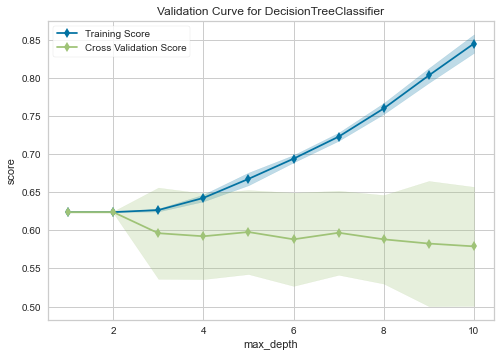

<AxesSubplot:title={'center':'Validation Curve for DecisionTreeClassifier'}, xlabel='max_depth', ylabel='score'>

In [60]:
from yellowbrick.model_selection import ValidationCurve
from sklearn.tree import DecisionTreeRegressor

viz = ValidationCurve(
    DecisionTreeClassifier(), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()

In [61]:
#len(list(set(df['region'].to_list())))

In [62]:
feature_names = ['black_fruit', 'citrus_fruit', 'dried_fruit', 'earth',
       'floral', 'microbio', 'non_oak', 'oak', 'red_fruit', 'spices',
       'tree_fruit', 'tropical_fruit', 'vegetal']
target_names = encoder.classes_

export_graphviz(clf, out_file="adspy_temp.dot", feature_names=feature_names, class_names=target_names, filled = True, impurity = False)

with open("adspy_temp.dot") as f:
    dot_graph = f.read()
# Alternate method using pydotplus, if installed.
my_graph = graphviz.Source(dot_graph)
my_graph.render('decision_tree_region',format='png', view=False)

'decision_tree_region.png'

/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


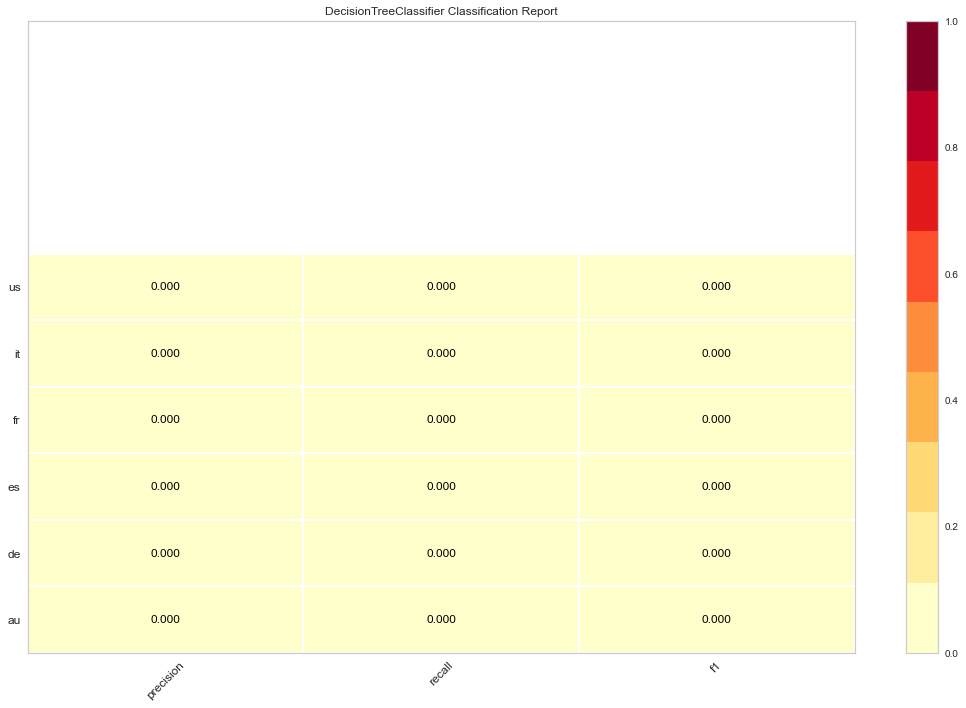

In [63]:
report = ClassificationReport(clf, size=(1080, 720), classes=encoder.classes_)

report.score(X_test, y_test)
c = report.poof()

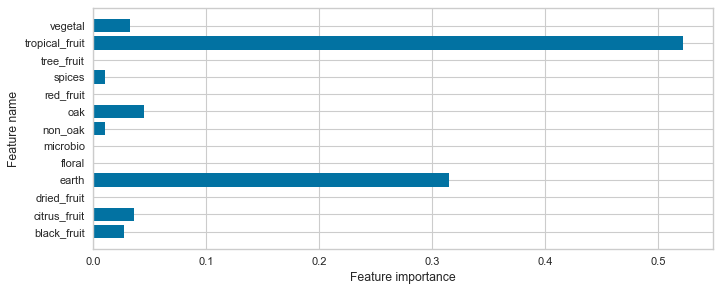

In [64]:
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf, feature_names)
plt.show()

/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


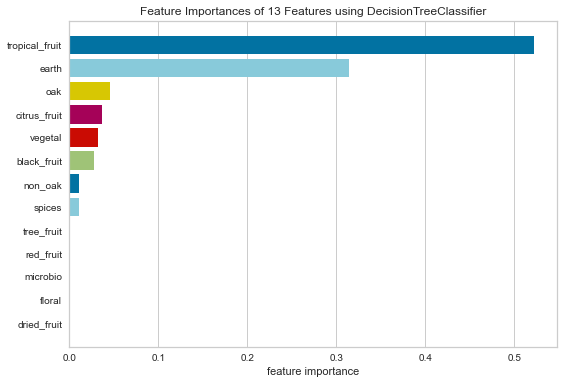

<AxesSubplot:title={'center':'Feature Importances of 13 Features using DecisionTreeClassifier'}, xlabel='feature importance'>

In [65]:
from yellowbrick.features import FeatureImportances
fig = plt.figure()
ax = fig.add_subplot()
viz = FeatureImportances(clf, relative=False)
viz.fit(X_train,y_train) # Fit the data to the visualizer
viz.poof()

# Random Forest Classifier
## classify region

In [66]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 10,
                            random_state=0).fit(X_train, y_train)
print('Random Forest, Flavor dataset, default settings') 
print('Accuracy of RF classifier on training set: {:.2f}'.format(clf.score(X_train, y_train))) 
print('Accuracy of RF classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Random Forest, Flavor dataset, default settings
Accuracy of RF classifier on training set: 0.99
Accuracy of RF classifier on test set: 0.03


/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


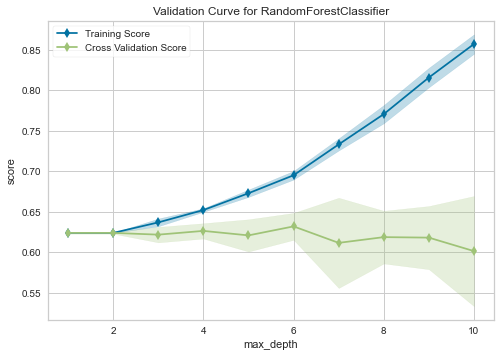

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>

In [67]:
from yellowbrick.model_selection import ValidationCurve
from sklearn.tree import DecisionTreeRegressor

viz = ValidationCurve(
    RandomForestClassifier(n_estimators = 10,random_state=0), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()

/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


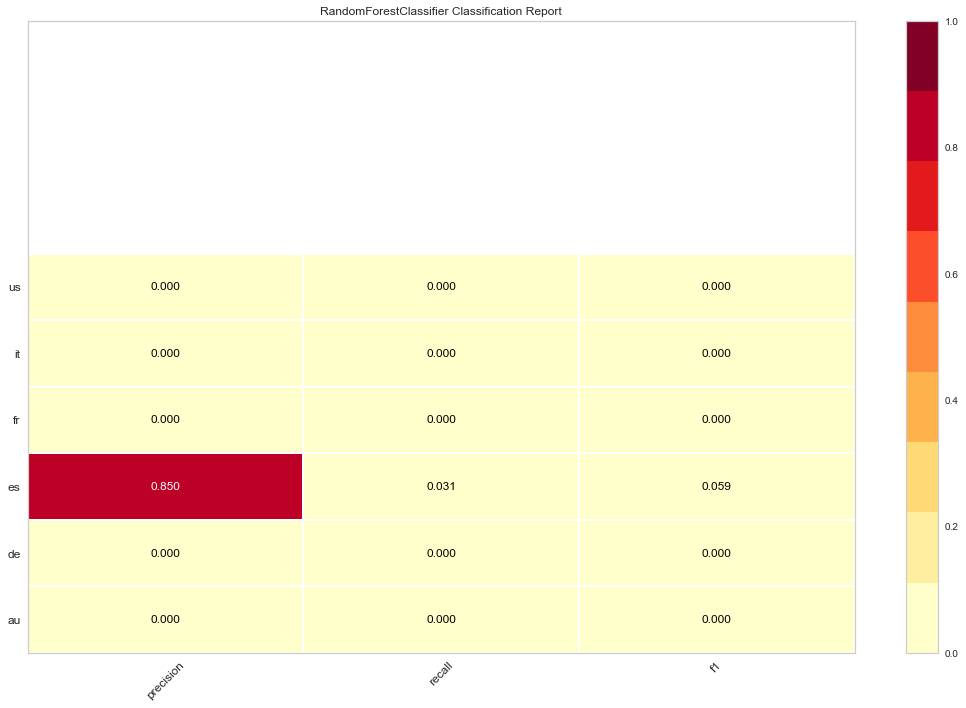

In [68]:
from sklearn.preprocessing import LabelEncoder
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError

model =  RandomForestClassifier(n_estimators = 10, random_state=0).fit(X_train, y_train)


report = ClassificationReport(model, size=(1080, 720), classes=encoder.classes_)

report.score(X_test, y_test)
c = report.poof()

/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


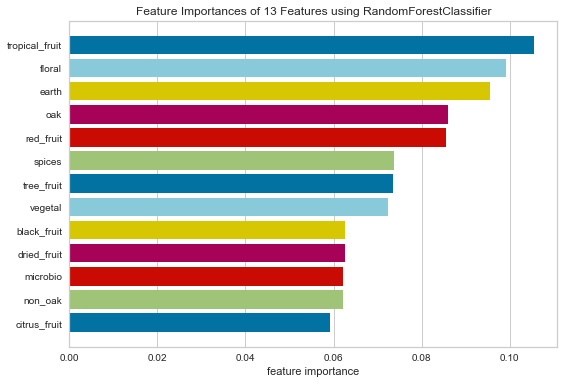

<AxesSubplot:title={'center':'Feature Importances of 13 Features using RandomForestClassifier'}, xlabel='feature importance'>

In [69]:
from yellowbrick.features import FeatureImportances
fig = plt.figure()
ax = fig.add_subplot()
viz = FeatureImportances(model, relative=False)
viz.fit(X_train,y_train) # Fit the data to the visualizer
viz.poof()

In [70]:
mapping = dict(zip(range(len(encoder.classes_)),encoder.classes_))

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder=mapping)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

mapping = dict(zip(range(len(encoder.classes_)),encoder.classes_))

from itertools import cycle
# Binarize the output
y = label_binarize(y, classes=list(set(df['country_name'])))
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

classifier = RandomForestClassifier(n_estimators = 10, random_state=0)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[i], y_score[i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# GaussianNB Classifier
## classify region

In [71]:
nbclf = GaussianNB().fit(X_train, y_train)
print('Wine dataset')
print('Accuracy of GaussianNB classifier on training set: {:.2f}'
.format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(nbclf.score(X_test, y_test)))

Wine dataset
Accuracy of GaussianNB classifier on training set: 0.28
Accuracy of GaussianNB classifier on test set: 0.10


# Gradient Boosting Classifier
## classify region

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier().fit(X_train, y_train)
print('Wine dataset')
print('Accuracy of GradientBoosting classifier on training set: {:.2f}'
.format(clf.score(X_train, y_train)))
print('Accuracy of GradientBoosting classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Wine dataset
Accuracy of GradientBoosting classifier on training set: 0.92
Accuracy of GradientBoosting classifier on test set: 0.02


from yellowbrick.model_selection import ValidationCurve
from sklearn.tree import DecisionTreeRegressor

viz = ValidationCurve(
    GradientBoostingClassifier(), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()

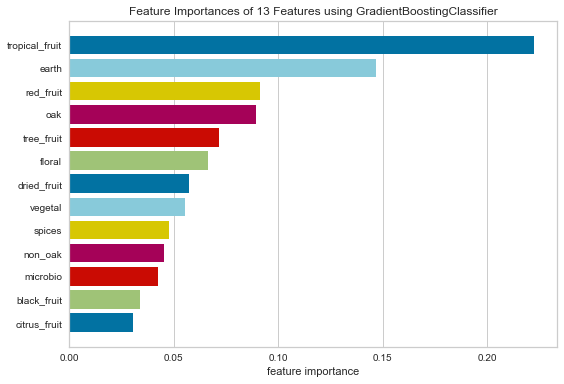

<AxesSubplot:title={'center':'Feature Importances of 13 Features using GradientBoostingClassifier'}, xlabel='feature importance'>

In [73]:
from yellowbrick.features import FeatureImportances
fig = plt.figure()
ax = fig.add_subplot()
viz = FeatureImportances(GradientBoostingClassifier(), relative=False)
viz.fit(X_train,y_train) # Fit the data to the visualizer
viz.poof() # Draw/show/poof the data

/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


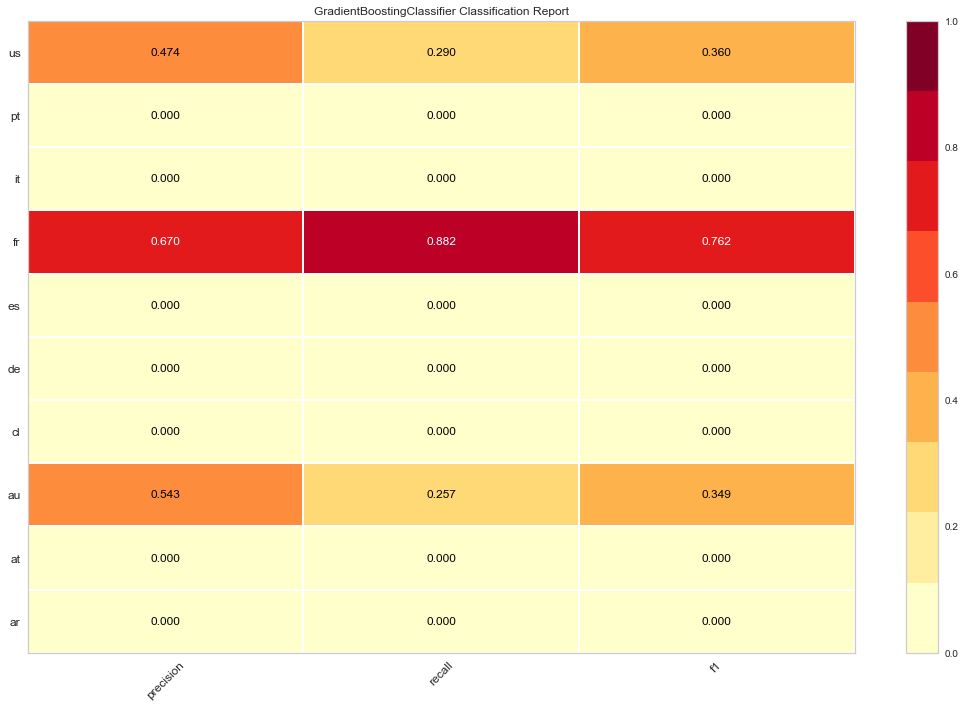

In [74]:
from sklearn.preprocessing import LabelEncoder

model = LinearSVC()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = GradientBoostingClassifier().fit(X_train, y_train)

report = ClassificationReport(clf, size=(1080, 720), classes=encoder.classes_)

report.score(X_test, y_test)
c = report.poof()

visualizer = ROCAUC(clf)
visualizer.score(X_test, y_test)
visualizer.show()

# Class Balance

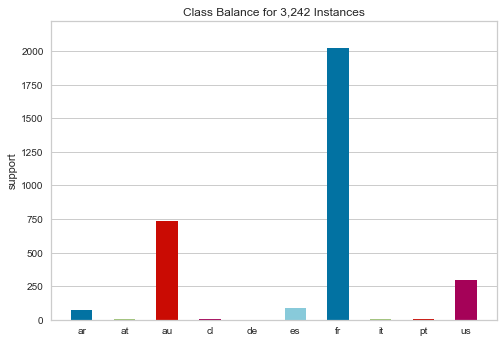

<AxesSubplot:title={'center':'Class Balance for 3,242 Instances'}, ylabel='support'>

In [75]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError

classes=list(set(df['country_name']))

visualizer = ClassBalance(labels=encoder.classes_)

visualizer.fit(y)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Wine dataset
Accuracy of XGBClassifier on training set: 0.86
Accuracy of XGBClassifier on test set: 0.64


/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


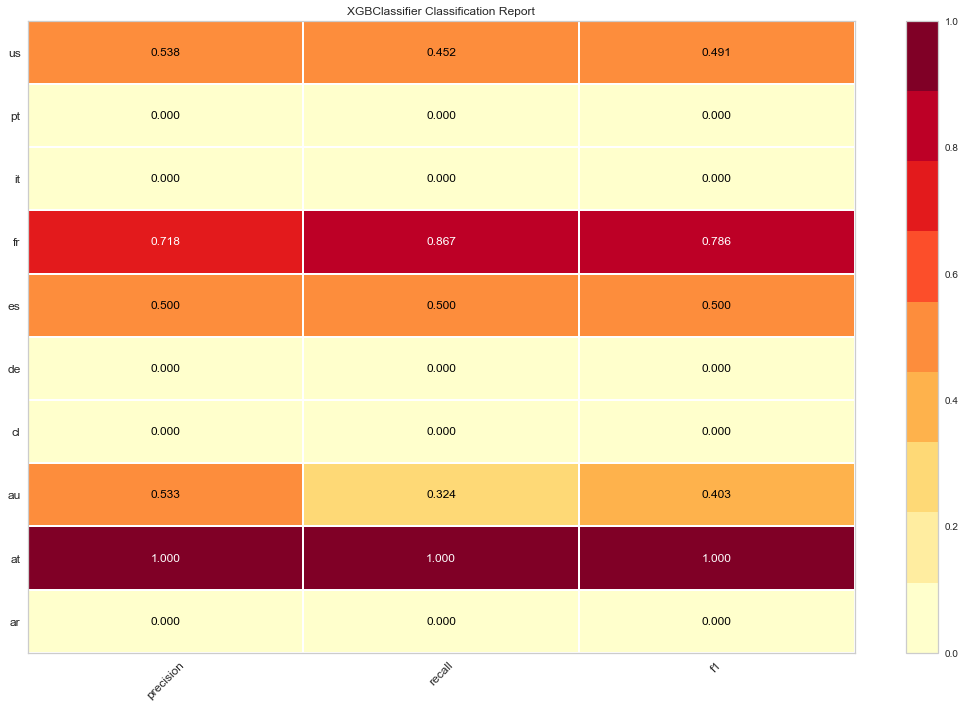

In [76]:
print('Wine dataset')
print('Accuracy of XGBClassifier on training set: {:.2f}'
.format(clf.score(X_train, y_train)))
print('Accuracy of XGBClassifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))


clf = XGBClassifier(n_jobs=-1, random_state=0,objective='multi:softprob')
clf.fit(X_train, y_train)

report = ClassificationReport(clf, size=(1080, 720), classes=encoder.classes_)

report.score(X_test, y_test)
c = report.poof()

/Users/chieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


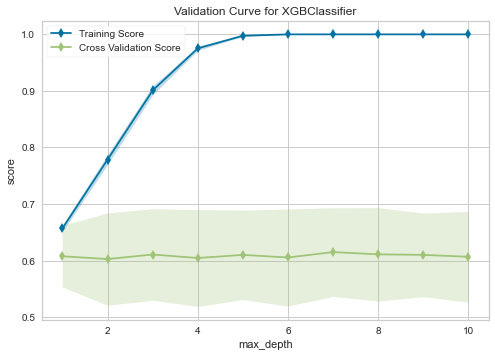

<AxesSubplot:title={'center':'Validation Curve for XGBClassifier'}, xlabel='max_depth', ylabel='score'>

In [77]:
from yellowbrick.model_selection import ValidationCurve
from sklearn.tree import DecisionTreeRegressor

viz = ValidationCurve(
    XGBClassifier(n_jobs=-1, random_state=0,objective='multi:softprob'), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()

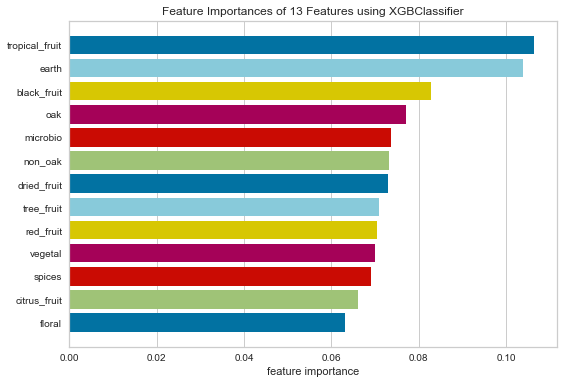

<AxesSubplot:title={'center':'Feature Importances of 13 Features using XGBClassifier'}, xlabel='feature importance'>

In [78]:
fig = plt.figure()
ax = fig.add_subplot()
viz = FeatureImportances(clf, relative=False)
viz.fit(X_train,y_train) # Fit the data to the visualizer
viz.poof()

[Text(0, 0, '0.61'),
 Text(0, 0, '0.65'),
 Text(0, 0, '0.66'),
 Text(0, 0, '0.63')]

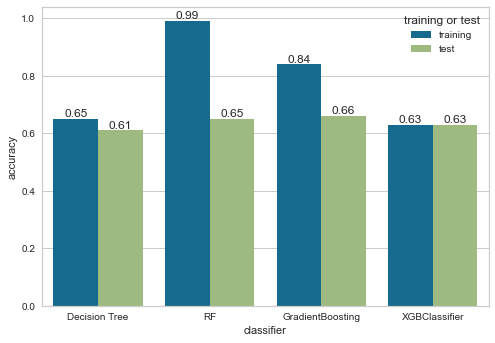

In [79]:
import seaborn as sns
d = {'classifier': ['Decision Tree','RF','GradientBoosting','XGBClassifier','Decision Tree','RF','GradientBoosting','XGBClassifier'], 'accuracy':[0.65, 0.99,0.84,0.63,0.61, 0.65,0.66,0.63],'training or test': ['training','training','training','training','test','test','test','test']}
df_ac = pd.DataFrame(data=d)

ax = sns.barplot(data=df_ac, x="classifier", y="accuracy",hue='training or test')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

# One Vs Rest Classifier
## classify region

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

clf = OneVsRestClassifier(LinearSVC(random_state=0)).fit(X_train, y_train)
print('Wine dataset')
print('Accuracy of OneVsRest classifier on training set: {:.2f}'
.format(clf.score(X_train, y_train)))
print('Accuracy of OneVsRest classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

# Visualize all the original dimensions

In [ ]:
import plotly.express as px

flavors = ['black_fruit', 'citrus_fruit', 'dried_fruit', 'earth',
       'floral', 'microbio', 'non_oak', 'oak', 'red_fruit', 'spices',
       'tree_fruit', 'tropical_fruit', 'vegetal']

fig = px.scatter_matrix(
    df,
    dimensions=flavors,
    color="country_name",
    width=1800, height=1400
)
fig.update_traces(diagonal_visible=False)
fig.show()

fig.write_html("scatter_plot_original.html")

# PCA

In [ ]:
from sklearn.decomposition import PCA
import plotly.express as px
pca = PCA()
components = pca.fit_transform(df[flavors])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=df["country_name"]
)
fig.update_traces(diagonal_visible=False)
fig.show()
fig.write_html("pca.html")

In [ ]:
import plotly.graph_objs as go

features = flavors
X = df[features]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=df['country_name'])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )

fig.show()
fig.write_html("pca_flavor.html")

# Price

In [ ]:
print(df['price'].quantile(0.2))
print(df['price'].quantile(0.4))
print(df['price'].quantile(0.6))
print(df['price'].quantile(0.8))

In [ ]:
cut_price = ['low','medium-low', "medium",'medium-high', 'high']
cut_bins =[0,df['price'].quantile(0.2), df['price'].quantile(0.4), df['price'].quantile(0.6), df['price'].quantile(0.8),50]
df['price_segment'] = pd.cut(df['price'], bins=cut_bins, labels = cut_price)
df

In [ ]:
order = ['low','medium-low', "medium",'medium-high', 'high']
df.price_segment.value_counts().loc[order].plot(kind = 'bar')

In [ ]:
df['price'].value_counts().hist()

In [ ]:
count

In [ ]:
#count = df['price'].value_counts()

fig, ax = plt.subplots()
ax.hist(df['price'].value_counts(), 30, histtype='bar')
plt.show()


In [ ]:
df.boxplot(column=['price'])  

In [ ]:
X = df[['black_fruit', 'citrus_fruit', 'dried_fruit', 'earth',
       'floral', 'microbio', 'non_oak', 'oak', 'red_fruit', 'spices',
       'tree_fruit', 'tropical_fruit', 'vegetal']]

encoder = LabelEncoder()
y = encoder.fit_transform(df['price_segment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.1)

In [ ]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}' .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}' .format(clf.score(X_test, y_test)))

In [ ]:
visualizer = ClassificationReport(clf, classes=['low','medium-low', "medium",'medium-high', 'high'])
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [ ]:
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf, feature_names)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
viz = FeatureImportances(clf, relative=False)
viz.fit(X_train,y_train) # Fit the data to the visualizer
viz.poof()

In [ ]:
model = LinearSVC().fit(X_train, y_train)
print('Accuracy of LinearSVC classifier on training set: {:.2f}'
.format(model.score(X_train, y_train)))
print('Accuracy of LinearSVC classifier on test set: {:.2f}'
     .format(model.score(X_test, y_test)))

In [ ]:
model = LinearSVC()

visualizer = ClassificationReport(model, classes=encoder.classes_)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [ ]:
nbclf = GaussianNB().fit(X_train, y_train)
print('Wine dataset')
print('Accuracy of GaussianNB classifier on training set: {:.2f}'
.format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(nbclf.score(X_test, y_test)))

In [ ]:
visualizer = ClassificationReport(nbclf, classes=encoder.classes_)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

# Rating

In [ ]:
print(df['rating'].quantile(0.25))
print(df['rating'].quantile(0.5))
print(df['rating'].quantile(0.75))

In [ ]:
cut_rating = ['bad','not bad', 'good', 'excellent']
cut_bins =[0, 3.8, 3.9, 4.1, 5]
df['rating_segment'] = pd.cut(df['rating'], bins=cut_bins, labels = cut_rating)
df

In [ ]:
order = ['bad','not bad', 'good', 'excellent']
df.rating_segment.value_counts().sort_values().loc[order].plot(kind = 'bar')

In [ ]:
order = ['bad','not bad', 'good', 'excellent']
df['rating'].value_counts().sort_index().plot(kind = 'bar')

In [ ]:
X = df[['black_fruit', 'citrus_fruit', 'dried_fruit', 'earth',
       'floral', 'microbio', 'non_oak', 'oak', 'red_fruit', 'spices',
       'tree_fruit', 'tropical_fruit', 'vegetal']]
encoder = LabelEncoder()
y = encoder.fit_transform(df['rating_segment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.1)

In [ ]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}' .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}' .format(clf.score(X_test, y_test)))

In [ ]:
clf = DecisionTreeClassifier()

visualizer = ClassificationReport(clf, classes=['bad','not bad', 'good', 'excellent'])
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
viz = FeatureImportances(clf, relative=False)
viz.fit(X_train,y_train) # Fit the data to the visualizer
viz.poof()

In [ ]:
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf, feature_names)
plt.show()

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

visualizer = ClassificationReport(model, classes=encoder.classes_)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [ ]:
nbclf = GaussianNB().fit(X_train, y_train)
print('Wine dataset')
print('Accuracy of GaussianNB classifier on training set: {:.2f}'
.format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(nbclf.score(X_test, y_test)))

In [ ]:
nbclf = GaussianNB()

visualizer = ClassificationReport(nbclf, classes=encoder.classes_)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

# Yellowbrick

In [ ]:
from yellowbrick.features import Rank2D
X = df[['black_fruit', 'citrus_fruit', 'dried_fruit', 'earth',
       'floral', 'microbio', 'non_oak', 'oak', 'red_fruit', 'spices',
       'tree_fruit', 'tropical_fruit', 'vegetal']]
features=['black_fruit', 'citrus_fruit', 'dried_fruit', 'earth',
       'floral', 'microbio', 'non_oak', 'oak', 'red_fruit', 'spices',
       'tree_fruit', 'tropical_fruit', 'vegetal']
visualizer = Rank2D(features=features, algorithm='covariance')
visualizer.fit(X, df['rating_segment']) # Fit the data to the visualizer
visualizer.transform(X) # Transform the data
visualizer.poof() # Draw/show/poof the data

In [ ]:
X = df[['black_fruit', 'citrus_fruit', 'dried_fruit', 'earth',
       'floral', 'microbio', 'non_oak', 'oak', 'red_fruit', 'spices',
       'tree_fruit', 'tropical_fruit', 'vegetal']]

encoder = LabelEncoder()
y = encoder.fit_transform(df['country_name'])

model = LinearSVC()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

visualizer = ClassificationReport(model, classes=list(set(df['country_name'])))
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data